In [54]:
import os

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import pandas as pd
import numpy as np
from utils import clean_sentences, show_history_graph
from trainer import Trainer

try:
  import google.colab
  IN_COLAB = True
  drive.mount('/content/drive')
except:
  IN_COLAB = False


In [55]:
if IN_COLAB:
    imdb_path = "/content/drive/MyDrive/Colab Notebooks/dataset/imdb_simple/IMDB Dataset.csv"
else:
    imdb_path = "dataset/IMDB Dataset.csv"

imdb_df = pd.read_csv(imdb_path)
print(len(imdb_df))

imdb_df['sentiment'].value_counts()
imdb_sentiment = imdb_df['sentiment'].map({'positive': 1, 'negative': 0})
print(imdb_sentiment.value_counts())

x = imdb_df['review'].to_numpy()
y = imdb_sentiment.to_numpy()
print(len(x), len(y))
print(x.shape, y.shape)
print(x[0])
print(y[0])

50000
sentiment
1    25000
0    25000
Name: count, dtype: int64
50000 50000
(50000,) (50000,)
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agree

In [56]:
# clean sentences
x = [clean_sentences(entry) for entry in x]

In [57]:
# word-level one-hot-tokenize

word_cnt = {}
len_list = []
for entry in x:
    length = 0
    for word in entry.split():
        word = word.lower()
        length += 1
        if word not in word_cnt:
            word_cnt[word] = 0
        word_cnt[word] = word_cnt[word] + 1
    len_list.append(length)

print("max sentence length:", np.max(len_list))
print("mean sentence length:", np.mean(len_list))
print("median sentence length:", np.median(len_list))

print("word max_size:", len(word_cnt))

top_10000_word = sorted(word_cnt.items(), key=lambda item: item[1], reverse=True)[:10000]
vocab = {'<PAD>':0, '<UNK>':1}
for item in top_10000_word:
    vocab[item[0]] = len(vocab)

print(vocab)


# make word to integer token and add pad or truncate
max_len = 200
x_word_token = []
len_list = []
for entry in x:
    sentence = []
    for word in entry.split()[:max_len]:
        word = word.lower()
        token = vocab[word] if word in vocab else vocab['<UNK>']
        sentence.append(token)
    pad_size = max_len - len(sentence)
    if pad_size > 0:
        sentence.extend([0]*pad_size)
    x_word_token.append(sentence)

print("vocab size:", len(vocab))

max sentence length: 2791
mean sentence length: 274.30138
median sentence length: 206.0
word max_size: 104883
{'<PAD>': 0, '<UNK>': 1, 'the': 2, '.': 3, ',': 4, 'and': 5, 'a': 6, 'of': 7, 'to': 8, 'is': 9, 'it': 10, 'in': 11, "'": 12, 'i': 13, 'this': 14, 'that': 15, '-': 16, '"': 17, 'was': 18, 'not': 19, 'as': 20, 'movie': 21, 'for': 22, 'with': 23, 's': 24, 'but': 25, 'film': 26, ')': 27, '(': 28, 'you': 29, 'on': 30, 'are': 31, 'have': 32, 'he': 33, 'his': 34, 'one': 35, 'be': 36, '!': 37, 'all': 38, 'at': 39, 'they': 40, 'by': 41, 'an': 42, 'who': 43, 'so': 44, 'from': 45, 'like': 46, 'there': 47, 'or': 48, 'just': 49, 'her': 50, 'out': 51, 'about': 52, 'if': 53, 'has': 54, 'do': 55, '?': 56, 'what': 57, 't': 58, 'some': 59, 'good': 60, 'can': 61, 'when': 62, 'more': 63, 'very': 64, 'would': 65, 'she': 66, 'up': 67, 'no': 68, 'time': 69, 'my': 70, 'even': 71, 'which': 72, 'only': 73, 'story': 74, 'really': 75, 'see': 76, 'their': 77, 'were': 78, 'had': 79, 'me': 80, 'well': 81, 'w

In [58]:
x_word_token = np.array(x_word_token)
x_word_token_tensors = torch.tensor(x_word_token, dtype=torch.long)
y_tensors = torch.tensor(y, dtype=torch.long)
print(x_word_token_tensors.shape)
print(y_tensors.shape)

torch.Size([50000, 200])
torch.Size([50000])


In [59]:
config = {
    'batch_size':256,
    'vocab_size':len(vocab),
    'embedding_dim':200,
    'hidden_size':128,
    'num_layers':1,
    'dropout':0,
}

In [60]:
imdb_dataset = TensorDataset(x_word_token_tensors, y_tensors)
train_dataset, val_dataset, test_dataset = random_split(imdb_dataset, [0.7, 0.15, 0.15])
print(f"train dataset:{len(train_dataset)}, val dataset:{len(val_dataset)}, test dataset:{len(test_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

train dataset:35000, val dataset:7500, test dataset:7500


In [61]:
class TorchLSTM(nn.Module):
    def __init__(self, config, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.config = config
        self.embedding = nn.Embedding(
            num_embeddings=config['vocab_size'], 
            embedding_dim=config['embedding_dim']
            )
        self.lstm = nn.LSTM(
            input_size=config['embedding_dim'], 
            hidden_size=config['hidden_size'], 
            num_layers=config['num_layers'], 
            bidirectional=True,
            batch_first=True, 
            dropout=config['dropout']
        )
        self.fnn = nn.Linear(
            in_features=config['hidden_size'] * 2, 
            out_features=1
            )
        
    def forward(self, x):
        out = self.embedding(x)
        output, _ = self.lstm(out)
        # output ( batch, seq_len, input_size)
        last_output = output[:, -1, :].squeeze()
        # last_output = (batch, input_size)
        out = self.fnn(last_output)
        return out

model = TorchLSTM(config)
sample_input = train_dataset[:config['batch_size']][0]
print(sample_input.shape)
test = model(sample_input)
print(test.shape)

torch.Size([256, 200])
torch.Size([256, 1])


start training : lr=0.001


 12%|█▏        | 12/100 [00:31<03:51,  2.63s/it, train_loss=0.15813, val_loss=0.40404, train_accu=0.95 val_accu=0.85]

Early stopping at epoch 12
output/TorchLSTM_ep_7_loss_0.3694.pt


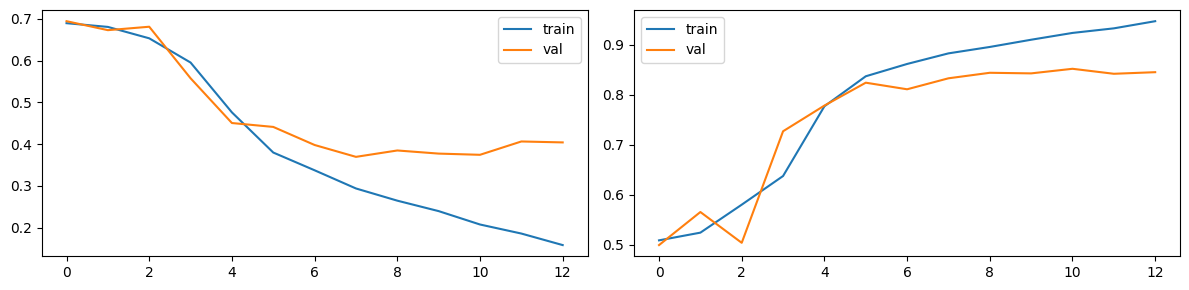

In [62]:
config['device'] = 'cuda' if torch.cuda.is_available() else "cpu"
config['epoch'] = 100
config['learning_rate'] = 1e-3
config['embedding_dim'] = 256
config['hidden_size'] = 64
config['num_layers'] = 3
config['dropout'] = 0.4

model = TorchLSTM(config)
trainer = Trainer(config, model, train_dataloader, val_dataloader)
history, last_ckpt_path = trainer.train()
show_history_graph(history)

In [63]:
print(last_ckpt_path)
model = TorchLSTM(config)
state_dict = torch.load(last_ckpt_path)
model.load_state_dict(state_dict)
model.to(config['device'])

loss, accuracy = trainer.test(model, test_dataloader)
print(f"test loss : {loss:.4f}, accuracy : {accuracy:.2f}")


output/TorchLSTM_ep_7_loss_0.3694.pt
test loss : 0.3792, accuracy : 0.86


In [64]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.xi = nn.Linear(input_size, hidden_size)
        self.hi = nn.Linear(hidden_size, hidden_size)
        self.xf = nn.Linear(input_size, hidden_size)
        self.hf = nn.Linear(hidden_size, hidden_size)
        self.xo = nn.Linear(input_size, hidden_size)
        self.ho = nn.Linear(hidden_size, hidden_size)

        self.xc = nn.Linear(input_size, hidden_size)
        self.hc = nn.Linear(hidden_size, hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
    
    def forward(self, x, h_0=None, c_0=None):
        h = h_0
        c = c_0
        if h is None:
            h = torch.zeros([x.shape[1], self.hidden_size])
            h = h.to(x.device)
        if c is None:
            c = torch.zeros([x.shape[1], self.hidden_size])
            c = c.to(x.device)
        
        hidden_states = []
        memories = []

        for i in range(x.shape[0]):
            i_gate = self.sigmoid(self.xi(x[i]) + self.hi(h))
            f_gate = self.sigmoid(self.xf(x[i]) + self.hf(h))
            o_gate = self.sigmoid(self.xo(x[i]) + self.ho(h))

            proposal = self.tanh(self.xc(x[i]) + self.hc(h))
            c = torch.mul(f_gate, c) + torch.mul(i_gate, proposal)
            h = torch.mul(o_gate, self.tanh(c))
            hidden_states.append(h)
            memories.append(c)
        
        hidden_states = torch.stack(hidden_states, dim=0)
        memories = torch.stack(memories, dim=0)

        return hidden_states, memories

lstm_cell = LSTMCell(input_size=100, hidden_size=256)
# sample (seq_len, batch, input_size)
sample = torch.zeros([50, 64, 100])
h, c = lstm_cell(sample)
print(h.shape, c.shape)


    
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_first=False, bidirectional=False, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bidirectional = bidirectional

        d = 2 if bidirectional else 1

        self.base_lstm = LSTMCell(input_size, hidden_size)
        self.base_lstm_r = None
        self.lstm_layers = nn.ModuleList(
            [LSTMCell(input_size=hidden_size * d, hidden_size=hidden_size) for _ in range(self.num_layers-1)]
        )
        self.lstm_layers_r = None
        if bidirectional:
            self.base_lstm_r = LSTMCell(input_size, hidden_size)
            self.lstm_layers_r = nn.ModuleList(
                [LSTMCell(input_size=hidden_size * d, hidden_size=hidden_size) for _ in range(self.num_layers-1)]
            )
    
    def forward(self, x, h_0=None, c_0=None):
        if self.batch_first:
            x = x.transpose(0, 1)
        
        h_n = []
        c_n = []
        output = []

        h, c = self.base_lstm(x, h_0, c_0)
        if self.bidirectional:
            h_r, c_r = self.base_lstm_r(torch.flip(x, [0]), h_0, c_0)
            h = torch.concat([h, h_r], dim=2)
            c = torch.concat([c, c_r], dim=2)
        h_n.append(h)
        c_n.append(h)
        output = h

        for i in range(len(self.lstm_layers)):
            layer = self.lstm_layers[i]
            h_new, c_new = layer(h, h_0, c_0)
            if self.bidirectional:
                layer_r = self.lstm_layers_r[i]
                h_new_r, c_new_r = layer_r(torch.flip(h, [0]), h_0, c_0)
                h = torch.concat([h_new, h_new_r], dim=2)
                c = torch.concat([c_new, c_new_r], dim=2)
            else:
                h = h_new
                c = c_new
            
            h_n.append(h)
            c_n.append(c)
            output = h 
        
        h_n = torch.stack(h_n, dim=0)
        c_n = torch.stack(c_n, dim=0)
        if self.batch_first:
            output = output.transpose(0, 1)
            h_n = h_n.transpose(1, 2)
            c_n = c_n.transpose(1, 2)
        return output, (h_n, c_n)


# lstm = LSTM(input_size=100, hidden_size=256, batch_first=False, bidirectional=True, num_layers=1)
# # sample (seq_len, batch, input_size)
# sample = torch.zeros([50, 64, 100])
# output, (h, c) = lstm(sample)
# print(output.shape, h.shape, c.shape)


lstm = LSTM(input_size=100, hidden_size=256, batch_first=False, bidirectional=False, num_layers=3)
# sample (seq_len, batch, input_size)
sample = torch.zeros([50, 64, 100])
output, (h, c) = lstm(sample)
print(output.shape, h.shape, c.shape)


torch.Size([50, 64, 256]) torch.Size([50, 64, 256])
torch.Size([50, 64, 256]) torch.Size([3, 50, 64, 256]) torch.Size([3, 50, 64, 256])


In [65]:
class MyLSTM(nn.Module):
    def __init__(self, config, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.config = config
        self.embedding = nn.Embedding(
            num_embeddings=config['vocab_size'], 
            embedding_dim=config['embedding_dim']
            )
        self.lstm = LSTM(
            input_size=config['embedding_dim'], 
            hidden_size=config['hidden_size'], 
            num_layers=config['num_layers'], 
            bidirectional=True,
            batch_first=True, 
        )
        self.fnn = nn.Linear(
            in_features=config['hidden_size'], 
            out_features=1
            )
        
    def forward(self, x):
        out = self.embedding(x)
        output, _ = self.lstm(out)
        # output ( batch, seq_len, input_size)
        last_output = output[:, -1, :].squeeze()
        # last_output = (batch, input_size)
        out = self.fnn(last_output)
        return out

model = MyLSTM(config)
sample_input = train_dataset[:config['batch_size']][0]
print(sample_input.shape)
test = model(sample_input)
print(test.shape)

torch.Size([256, 200])
torch.Size([256, 1])


start training : lr=0.001


 21%|██        | 21/100 [32:57<2:03:59, 94.17s/it, train_loss=0.14928, val_loss=0.40511, train_accu=0.95 val_accu=0.85]

Early stopping at epoch 21
output/MyLSTM_ep_16_loss_0.3674.pt


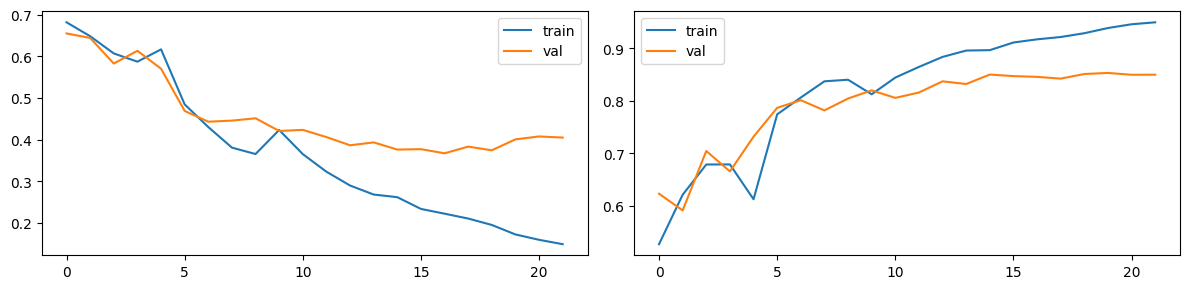

In [67]:
config['device'] = 'cuda' if torch.cuda.is_available() else "cpu"
config['epoch'] = 100
config['learning_rate'] = 1e-3
config['embedding_dim'] = 256
config['hidden_size'] = 64
config['num_layers'] = 3
config['dropout'] = 0.4

model = MyLSTM(config)
trainer = Trainer(config, model, train_dataloader, val_dataloader)
history, last_ckpt_path = trainer.train()
show_history_graph(history)